In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from scipy.interpolate import BSpline

Set Up B-Spline Basis

In [3]:
def bspline_basis(t, d, n):
    '''
    Return the nth b spline basis where n = range(0,len(t)-d-1)
    given knot points t. 
    '''
    cn = np.zeros(len(t)-d-1); cn[n] = 1
    return BSpline(t,cn,d)

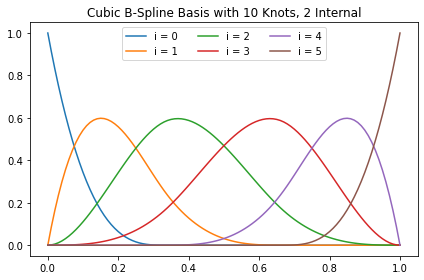

In [4]:
t = [0,0,0,0,1./3,2./3,1,1,1,1]
xs = np.arange(0,1.01,0.01)
for ii in range(6):
    spl = bspline_basis(t, 3, ii)
    plt.plot(xs, spl(xs),label='i = '+str(ii))

plt.legend(ncol=3)
plt.title('Cubic B-Spline Basis with 10 Knots, 2 Internal')
plt.tight_layout()
plt.show()

In [5]:
theta2p7 = 2.728 / 2.7;
h = 0.6736; hfac = 100000./299792458
om = 0.315; ob = 0.0493; omh = om*h; omh2 = om*h**2

ns = 0.9649; sigma8 = 0.808

In [6]:
ks, ps = np.loadtxt('./desi_pk.txt', unpack=True)

In [7]:
ks.shape

(2000,)

Eisenstein and Hu

In [8]:
z_eq = 25000 * omh2 * theta2p7**(-4)
keq = np.sqrt(2*omh2*hfac**2*z_eq)

B1 = 0.313*(omh2)**(-0.419) * (1+0.607*omh2**0.674)
B2 = 0.238 * omh2**0.223
z_d = 1291 * omh2**0.251 / (1 + 0.659*omh2**0.828 ) *(1 + B1*(ob*h**2)**B2)

Rfunc = lambda z: 31.5 * ob*h**2 * theta2p7**(-4) * (z/1000)**(-1)
Req = Rfunc(z_eq); Rd = Rfunc(z_d)


def T_nw(k):

    alpha_gamma = 1 - 0.328*np.log(431*omh2) * (ob/om) + 0.38 * np.log(22.3*omh2) * (ob/om)**2
    s = 2./(3*keq) * np.sqrt(6/Req) * np.log( (np.sqrt(1+Rd) + np.sqrt(Rd+Req))/(1+np.sqrt(Req))     )
    Gamma = omh * ( alpha_gamma + (1-alpha_gamma)/(1 + (0.43*k*s)**4) )
    q = k/h * theta2p7**2/Gamma
    
    L0 = np.log(2*np.e + 1.8*q)
    C0 = 14.2 + 731/(1+62.5*q)

    T0 = L0/(L0 + C0 * q**2)
    
    return T0

In [9]:
def P_nw(k):
    
    A = ps[0] / ks[0]**ns
    
    return A * k**ns * T_nw(h*k)**2

In [10]:
# First normalize the no-wiggle spectrum:
P_EH = P_nw(ks)

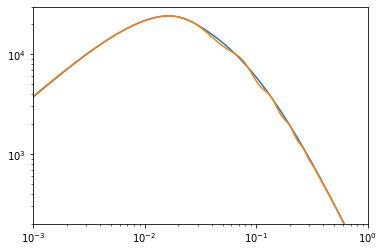

In [11]:
plt.loglog(ks, P_EH)
plt.loglog(ks, ps)

plt.xlim(1e-3,1)
plt.ylim(200,30000)
plt.show()

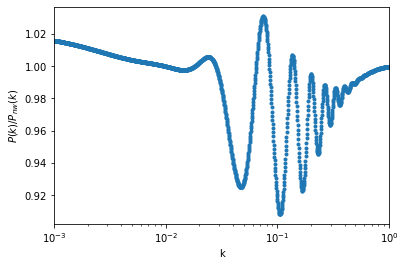

In [12]:
plt.semilogx(ks, ps/P_EH, '.')
plt.xlim(1e-3,1)
#plt.ylim(0.92,1.06)

plt.xlabel('k')
plt.ylabel(r'$P(k)/P_{nw}(k)$')

plt.show()

In [13]:
kmin, kmax = 0.005, 1.0

iis = (ks > kmin) * (ks < kmax)
fitks = np.log10(ks[iis])
fitps = (ps / P_EH)[iis]

Text(0, 0.5, 'w(k)')

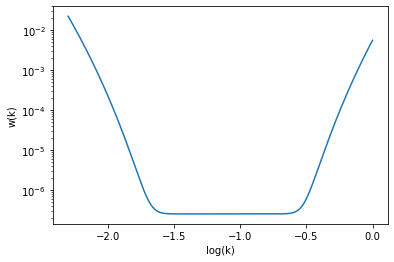

In [14]:
# Weights for the k points
# We want to make the b-splines asymptotically correct but not fit the wiggles
# So weight the points on the edges more

weights = 1 + 1000000*np.tanh(0.005*(fitks + 1.1)**16);
weights /= np.sum(weights)

plt.semilogy(fitks, weights)
plt.xlabel('log(k)')
plt.ylabel('w(k)')

Define the Model: Linear Sum of B-Splines

In [15]:
from scipy.optimize import least_squares

In [16]:
def linear_model(coeffs, basis, xdats = fitks):
    return sum( coeffs[ii] * basis[ii](xdats) for ii in range(len(coeffs)) )

def linear_residuals(coeffs, basis, xdats = fitks, ydats = fitps, weights = 1):
    fitdats = linear_model(coeffs, basis, xdats = fitks)
    r2 = np.sqrt(weights) * (ydats-fitdats)
    return r2

In [17]:
# Generate Zvonimir's set of bases:
num_knots = [14,14,15]
ds = [5,6,7]

bases = []
params = []

for m, d in zip(num_knots,ds):

    ts = np.concatenate( (np.zeros(d+1), (np.arange(m-2*d-1)+1)/(m-2*d) ,np.ones(d+1) )   )
    ts = (kmax-kmin)*ts + kmin
    bs = [ bspline_basis(ts,d,ii) for ii in range(m-d) ]
    
    res_w = least_squares(linear_residuals, x0=np.ones(len(bs)), args=(bs,), kwargs={"weights":weights})
    
    bases += [bs,]
    params += [res_w.x,]

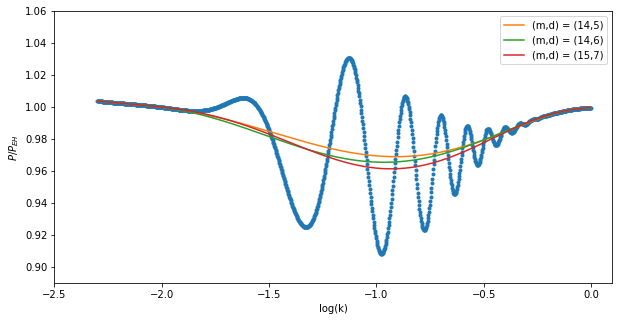

In [18]:
plt.figure(figsize=(10,5))

plt.plot(fitks, fitps,'.')
for m, d, param, b in zip(num_knots, ds, params, bases):
    plt.plot(fitks, linear_model(param,b),label='(m,d) = ('+str(m) + ',' + str(d) + ')')
    
plt.ylim(0.89,1.06)
plt.xlim(-2.5,0.1)

plt.legend()
plt.xlabel('log(k)')
plt.ylabel(r'$P/P_{EH}$')

plt.show()

Find Sum of These Functions That Preserves \sigma_8 and \sigma_v

In [19]:
from scipy.integrate import simps
SphericalTopHat = lambda k, R: 3 * (np.sin(k*R)-k*R*np.cos(k*R))/(k*R)**3

s8 = 1/(2*np.pi**2) * simps(ks**2*ps*SphericalTopHat(ks,8)**2,x=ks) 
sv = 1/(2*np.pi**2) * simps(ks**0*ps,x=ks)/3

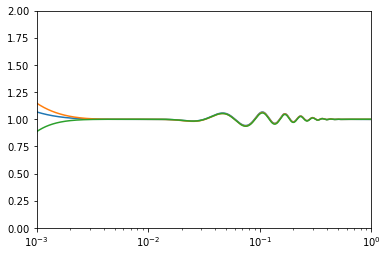

In [20]:
# Compute sigma8 for each template

logks = np.log10(ks)
s8s = []; svs = []

for param, b in zip(params,bases):
    pnw = P_nw(ks) * linear_model(param,b,xdats=logks)
    
    s8s += [1/(2*np.pi**2) * simps(ks**2*pnw*SphericalTopHat(ks,8)**2,x=ks)  ]
    svs += [1/(2*np.pi**2) * simps(ks**0*pnw,x=ks)/3  ]
    
    plt.semilogx(ks,pnw/ps)
    
#plt.semilogx(ks,ks*ps)

plt.xlim(1e-3,1)
plt.ylim(0,2)
plt.show()

In [21]:
# Solve for linear combination
A = np.array([[1,1,1],[s8s[0],s8s[1],s8s[2]],[svs[0],svs[1],svs[2]]])
b = np.array([1,s8,sv])

x = np.linalg.solve(A,b)
print(x)

[-0.67690811  1.01300074  0.66390737]


0 -0.6769081081948163
1 1.0130007398898229
2 0.6639073683049934


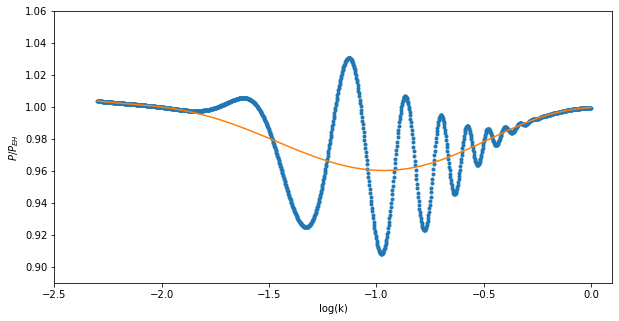

In [22]:
# Plot Result!

pnw = np.zeros_like(fitks)

for ii in range(3):
    print(ii,x[ii])
    pnw += x[ii] * linear_model(params[ii],bases[ii])

plt.figure(figsize=(10,5))

plt.plot(fitks, fitps,'.')
plt.plot(fitks, pnw)
    
plt.ylim(0.89,1.06)
plt.xlim(-2.5,0.1)

plt.xlabel('log(k)')
plt.ylabel(r'$P/P_{EH}$')

plt.show()

0 -0.6769081081948163
1 1.0130007398898229
2 0.6639073683049934


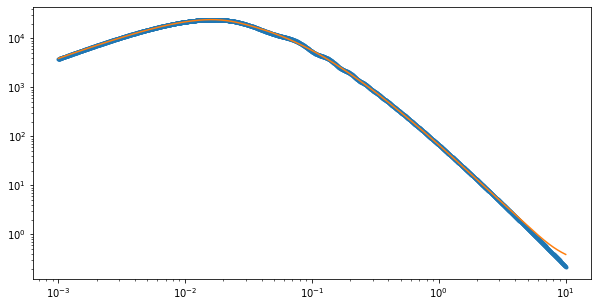

In [23]:
# In Log Space

pnw = np.zeros_like(ks)

for ii in range(3):
    print(ii,x[ii])
    pnw += x[ii] * linear_model(params[ii],bases[ii], xdats=np.log10(ks))

pnw *= P_EH    

plt.figure(figsize=(10,5))

plt.loglog(ks, ps,'.')
plt.loglog(ks, pnw)
    
#plt.ylim(0.91,1.06)
#plt.xlim(-2.1,0.1)

#plt.xlabel('log(k)')
#plt.ylabel(r'$P/P_{EH}$')

plt.show()

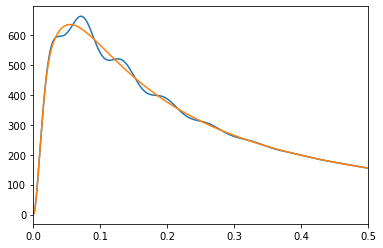

In [24]:
# In the familiar form

plt.plot(ks, ks * ps)
plt.plot(ks, ks * pnw)
    
    
plt.xlim(0,0.5)

plt.show()

(-0.1, 0.1)

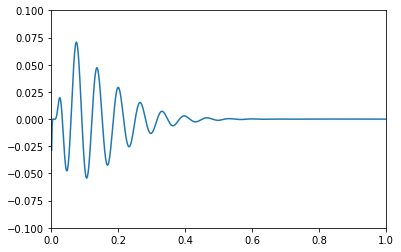

In [25]:
# What does P_w look like?

plt.plot(ks, ps/pnw - 1)

plt.xlim(0,1)

plt.ylim(-0.1,0.1)

In [26]:
np.savetxt('desi_pnw_bspline.txt',np.array([ks, pnw]).T)

Also Test Savitsky Golay Method

In [27]:
from scipy.signal import savgol_filter

In [28]:
pnw_sg = savgol_filter(ps/P_EH, 501, 4) * P_EH

(0.0, 0.4)

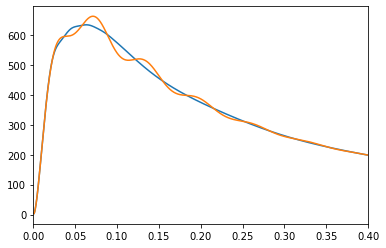

In [29]:
plt.plot(ks, ks * pnw_sg)
plt.plot(ks, ks * ps)

plt.xlim(0,0.4)

plt.semilogx(ks, pnw_sg/ps)

In [30]:
np.savetxt('desi_pnw_sg.txt', np.array([ks,pnw_sg]).T)

Discrete Sine Transform Method

In [31]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.signal import argrelmin, argrelmax, tukey
from scipy.fftpack import dst, idst
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

def pnw_dst(k,p, ii_l=None,ii_r=None,extrap_min=1e-3, extrap_max=10, N=16):
    
    '''
    Implement the wiggle/no-wiggle split procedure from Benjamin Wallisch's thesis (arXiv:1810.02800)
    
    '''

    # put onto a linear grid
    ks = np.linspace( extrap_min, extrap_max, 2**N)
    lnps = Spline(k, np.log(k*p), ext=1)(ks)
 
    
    # sine transform
    dst_ps = dst(lnps)
    dst_odd = dst_ps[1::2]
    dst_even = dst_ps[0::2]
    
    # find the BAO regions
    if ii_l is None or ii_r is None:
        d2_even = np.gradient( np.gradient(dst_even) )
        ii_l = argrelmin(gaussian_filter(d2_even,4))[0][0]
        ii_r = argrelmax(gaussian_filter(d2_even,4))[0][1]
        print(ii_l,ii_r)
    
        iis = np.arange(len(dst_odd))
        iis_div = np.copy(iis); iis_div[0] = 1.
        #cutiis_odd = (iis > (ii_l-3) ) * (iis < (ii_r+20) )
        cutiis_even = (iis > (ii_l-3) ) *  (iis < (ii_r+10) )
        
        d2_odd = np.gradient( np.gradient(dst_odd) )
        ii_l = argrelmin(gaussian_filter(d2_odd,4))[0][0]
        ii_r = argrelmax(gaussian_filter(d2_odd,4))[0][1]
        print(ii_l,ii_r)
    
        iis = np.arange(len(dst_odd))
        iis_div = np.copy(iis); iis_div[0] = 1.
        cutiis_odd = (iis > (ii_l-3) ) * (iis < (ii_r+20) )
        #cutiis_even = (iis > (ii_l-3) ) *  (iis < (ii_r+10) )
        
    else:
        iis = np.arange(len(dst_odd))
        iis_div = np.copy(iis); iis_div[0] = 1.
        cutiis_odd = (iis > (ii_l) ) * (iis < (ii_r) )
        cutiis_even = (iis > (ii_l) ) *  (iis < (ii_r) )

    # ... and interpolate over them
    interp_odd = interp1d(iis[~cutiis_odd],(iis**2*dst_odd)[~cutiis_odd],kind='cubic')(iis)/iis_div**2 
    interp_odd[0] = dst_odd[0]
    
    interp_even = interp1d(iis[~cutiis_even],(iis**2*dst_even)[~cutiis_even],kind='cubic')(iis)/iis_div**2 
    interp_even[0] = dst_even[0]
    
    # Transform back
    interp = np.zeros_like(dst_ps)
    interp[0::2] = interp_even
    interp[1::2] = interp_odd

    lnps_nw = idst(interp) / 2**17
    
    return k, Spline(ks, np.exp(lnps_nw)/ks,ext=1)(k)

knw, pnw_dst = pnw_dst(ks, ps)

123 181
122 181


(0.0, 0.4)

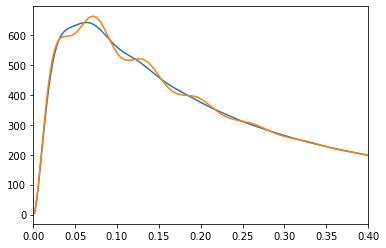

In [32]:
plt.plot(ks, ks * pnw_dst)
plt.plot(ks, ks * ps)

plt.xlim(0,0.4)

In [33]:
np.savetxt('desi_pnw_dst.txt', np.array([ks,pnw_dst]).T)

All together

(0.0, 0.4)

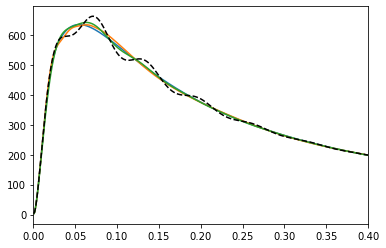

In [34]:
plt.plot(ks, ks * pnw)
plt.plot(ks, ks * pnw_sg)
plt.plot(ks, ks * pnw_dst)

plt.plot(ks, ks * ps, 'k--')

plt.xlim(0,0.4)

Text(0, 0.5, '$P/P_{nw} - 1$')

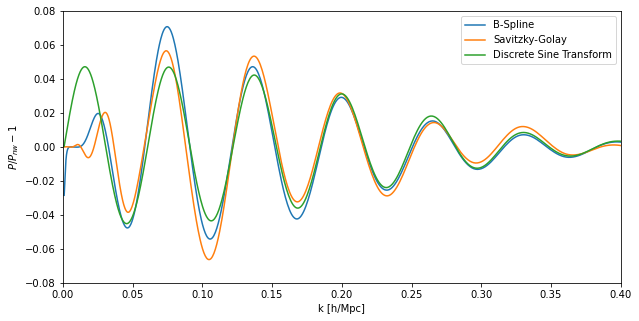

In [43]:
plt.figure(figsize=(10,5))

plt.plot(ks, ps/pnw - 1, label='B-Spline')
plt.plot(ks, ps/pnw_sg - 1, label='Savitzky-Golay')
plt.plot(ks, ps/pnw_dst - 1, label='Discrete Sine Transform')

plt.legend()

plt.xlim(0.00,0.4)
plt.ylim(-0.08, 0.08)

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$P/P_{nw} - 1$')

In [36]:
ks

array([1.00000000e-03, 1.00461810e-03, 1.00925754e-03, ...,
       9.90827380e+00, 9.95403124e+00, 1.00000000e+01])